In [1]:
!pip install -q -U watermark

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.0 MB/s eta 0:00:00


In [2]:
!pip install -q spacy

In [3]:
!pip install -q tensorflow

In [4]:
!pip install -q keras

In [5]:
!pip install -q keras-preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.5 MB/s eta 0:00:00


In [6]:
!pip install -q transformers

In [7]:
%env TF_CPP_MIN_LOG_LEVEL=3

env: TF_CPP_MIN_LOG_LEVEL=3


In [8]:
# Imports
import math
import nltk
import spacy
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import transformers
from tokenizers import BertWordPieceTokenizer
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.metrics import Precision, Recall, AUC
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, LearningRateScheduler, CallbackList, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from keras.saving import register_keras_serializable
from tensorflow.keras.layers import Layer, Dense
from transformers import TFDistilBertModel, DistilBertConfig
from tensorflow.keras.metrics import Precision, Recall, AUC
import warnings
warnings.filterwarnings('ignore')

## Loading text data

In [10]:
# Loading Train and Test Data
df_train = pd.read_csv("train_data.txt", header = None, delimiter = ';').rename(columns = {0: "text", 1: "label"})
df_test = pd.read_csv("test_data.txt", header = None, delimiter = ';').rename(columns = {0: "text", 1: "label"})

> A coluna **texto** será a variável de entrada e **sentimento** a variável de saída.

## SpaCy preprocessing the text data

https://spacy.io/

In [11]:
!python -m spacy download en_core_web_md -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 16.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [12]:
spacy_nlp = spacy.load("en_core_web_md")

In [13]:
def text_preprocess(text):

    doc = spacy_nlp(text)
    tokens = [token.lemma_.lower().strip() for token in doc if not token.is_stop]
    return " ".join(tokens)

df_train["processed_text"] = df_train["text"].apply(text_preprocess)
df_test["processed_text"] = df_test["text"].apply(text_preprocess)

## Model Version 2 - LSTM (Long Short-Term Memory)

In [ ]:
# Preprocess data
df_train.head()

In [ ]:
model_tokenizer = Tokenizer()

model_tokenizer.fit_on_texts(df_train["processed_text"])
word_index = model_tokenizer.word_index

train_sequences = model_tokenizer.texts_to_sequences(df_train["processed_text"])

max_length = 100
train_padded_sequences = pad_sequences(train_sequences, maxlen=max_length, truncating="post")

In [ ]:
test_sequences = model_tokenizer.texts_to_sequences(df_test["processed_text"])
test_sequences_padded = pad_sequences(test_sequences, maxlen = max_length)

model_le = LabelEncoder()

y_train_le = model_le.fit_transform(df_train["label"])
y_test_le = model_le.transform(df_test["label"])

y_train_encoded = to_categorical(y_train_le)
y_test_encoded = to_categorical(y_test_le)

vocab_size = len(model_tokenizer.word_index) + 1
print(vocab_size)

In [ ]:
embedding_dim = max_length

In [ ]:
# LSTM model build
model_v2 = tf.keras.Sequential([Embedding(vocab_size, embedding_dim, input_length = max_length),
  Bidirectional(LSTM(64)),
  Dropout(0.4),
  Dense(32, activation="leaky_relu", # (Leaky Rectified Linear Unit)
    kernel_regularizer = l1_l2(l1 = 0.01, l2 = 0.01)
  ),
  Dropout(0.4),
  Dense(6, activation="softmax")]
)

In [ ]:
# Model Compile
model_v2.compile(loss = "categorical_crossentropy",
  optimizer = "adam",
  metrics = ["accuracy", Precision(), Recall(), AUC()]
)

# Summary
print(model_v2.summary())

In [ ]:
test_sequences = model_tokenizer.texts_to_sequences(df_test["processed_text"])
test_sequences_padded = pad_sequences(test_sequences, maxlen = max_length)

model_le = LabelEncoder()

y_train_le = model_le.fit_transform(df_train["label"])
y_test_le = model_le.transform(df_test["label"])

y_train_encoded = to_categorical(y_train_le)input_data = np.array(train_padded_sequences)
y_test_encoded = to_categorical(y_test_le)

vocab_size = len(model_tokenizer.word_index) + 1
print(vocab_size)

In [ ]:
test_sequences = model_tokenizer.texts_to_sequences(df_test["processed_text"])
test_sequences_padded = pad_sequences(test_sequences, maxlen = max_length)

model_le = LabelEncoder()

y_train_le = model_le.fit_transform(df_train["label"])
y_test_le = model_le.transform(df_test["label"])

y_train_encoded = to_categorical(y_train_le)
y_test_encoded = to_categorical(y_test_le)

vocab_size = len(model_tokenizer.word_index) + 1
print(vocab_size)

In [ ]:
input_data = np.array(train_padded_sequences)
output_date = np.array(y_train_encoded)

num_epochs = 35
validation_split_value = 0.2
pacience_val = 5

early_stopping = tf.keras.callbacks.EarlyStopping(patience = pacience_val)

In [ ]:
%%time
history = model_v2.fit(input_data,
  output_date,
  epochs=num_epochs,
  verbose=1,
  validation_split=validation_split_value,
  callbacks=[early_stopping]
)

In [ ]:
# Error curves
loss, val_loss = history.history["loss"], history.history["val_loss"]
plt.plot(loss, label = "Train error")
plt.plot(val_loss, label = "Val error")
plt.legend()
plt.show()

In [ ]:
# Test predicts
test_predicts = model_v2.predict(test_sequences_padded)

In [ ]:
predicted_labels = test_predicts.argmax(axis=1)

print(classification_report(y_test_le, predicted_labels))

In [ ]:
# Confusion Matrix
print(confusion_matrix(y_test_le, predicted_labels))

In [ ]:
# Accuracy score
print(accuracy_score(y_test_le, predicted_labels))

In [ ]:
# Saving the model
model_v2.save("model_v2_dsa.keras")

In [ ]:
# Loading the saved Model
loaded_model = load_model("model_v2_dsa.keras")

# New sentence (sentiment = fear)
text = "i even feel a little shaky"

df_new = pd.DataFrame({"text": [text]})
df_new["processed_text"] = df_new["text"].apply(text_preprocess)
sequences_new = model_tokenizer.texts_to_sequences(df_new["processed_text"])
sequences_new_padded = pad_sequences(sequences_new, maxlen = max_length)

previsoes = loaded_model.predict(sequences_new_padded)
classe_maior_prob = np.argmax(previsoes, axis = 1)
class_name = model_le.inverse_transform(classe_maior_prob)

class_name

## Model Version 3 - Fine Tuning of a pre-trained model

In [39]:
def model_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    input_ids = []
    attention_masks = []

    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encodings = tokenizer(
            text_chunk,
            padding="max_length",
            truncation=True,
            max_length=maxlen,
            return_tensors="np"
        )
        input_ids.extend(encodings["input_ids"])
        attention_masks.extend(encodings["attention_mask"])

    return np.array(input_ids), np.array(attention_masks)

bert_tokenizer = transformers.DistilBertTokenizer.from_pretrained("distilbert-base-multilingual-cased")
bert_tokenizer.save_pretrained(".")

fast_tokenizer = transformers.DistilBertTokenizerFast.from_pretrained("distilbert-base-multilingual-cased")

X_train, X_val, Y_train, Y_val = train_test_split(df_train["processed_text"].values,
  df_train["label"].values,
  test_size=0.2,
  random_state=42,
  stratify=df_train["label"],
)

max_length = 100

X_train_final, mask_train = model_encode(X_train, fast_tokenizer, maxlen=max_length)
X_val_final, mask_val = model_encode(X_val, fast_tokenizer, maxlen=max_length)
X_test_final, mask_test = model_encode(df_test["processed_text"].to_numpy(),
  fast_tokenizer,
  maxlen=max_length,
)

100%|██████████| 8/8 [00:00<00:00, 28.95it/s]


In [40]:
df_le_v3 = LabelEncoder()

y_train_le = df_le_v3.fit_transform(Y_train)
y_val_le = df_le_v3.transform(Y_val)
y_test_le = df_le_v3.transform(df_test["label"])

y_treino_encoded = to_categorical(y_train_le)
y_valid_encoded = to_categorical(y_val_le)
y_teste_encoded = to_categorical(y_test_le)

BATCH_SIZE = 16

train_dataset = (
  tf.data.Dataset
  .from_tensor_slices(((X_train_final, mask_train), y_treino_encoded))
  .repeat()
  .shuffle(2048)
  .batch(BATCH_SIZE)
)

val_dataset = (
  tf.data.Dataset
  .from_tensor_slices(((X_val_final, mask_val), y_valid_encoded))
  .batch(BATCH_SIZE)
  .cache()
)

test_dataset = (
  tf.data.Dataset
  .from_tensor_slices(((X_test_final, mask_test), y_teste_encoded))
  .batch(BATCH_SIZE)
)

In [42]:
def create_model_v3(transformer, max_len=512):
    input_word_ids = tf.keras.layers.Input(
        shape=(max_len,),
        dtype=tf.int32,
        name="input_word_ids",
    )
    attention_mask = tf.keras.layers.Input(
        shape=(max_len,),
        dtype=tf.int32,
        name="attention_mask",
    )
    sequence_output = TransformerLayer(transformer)(
        [
            input_word_ids,
            attention_mask,
        ]
    )

    cls_token = sequence_output[:, 0, :]

    out = Dense(6,
      activation="softmax",
    )(cls_token)

    model = tf.keras.Model(
        inputs=[
                  input_word_ids,
                  attention_mask,
                ],
        outputs=out
    )

    model.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss="categorical_crossentropy",
        metrics=[
            "accuracy",
            Precision(),
            Recall(),
            AUC()
          ],
    )

    return model

In [64]:
@register_keras_serializable(package="Custom", name="TransformerLayer")
class TransformerLayer(tf.keras.layers.Layer):
    def __init__(self, transformer, **kwargs):
        super().__init__(**kwargs)
        self.transformer = transformer

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state

    def get_config(self):
        config = super().get_config()
        config.update({
            "transformer_name": self.transformer.name_or_path,
        })
        return config

    @classmethod
    def from_config(cls, config):
        transformer_name = config.pop("transformer_name")
        transformer = TFDistilBertModel.from_pretrained(transformer_name)
        return cls(transformer=transformer, **config)


In [65]:
transformer_layer = TFDistilBertModel.from_pretrained("distilbert-base-multilingual-cased")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [66]:
model_v3 = create_model_v3(transformer_layer, max_len=max_length)

In [67]:
model_v3.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_word_ids            │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_layer_2       │ (None, 100, 768)       │              0 │ input_word_ids[0][0],  │
│ (TransformerLayer)        │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 768)            │              0 │ transformer_layer_2[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 6)              │          4,614 │ get_item_2[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,614 (18.02 KB)

 Trainable params: 4,614 (18.02 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
model_v3.layers[0].trainable = False
model_v3.layers[1].trainable = False
model_v3.layers[2].trainable = False

In [69]:
model_v3.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_word_ids            │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_layer_2       │ (None, 100, 768)       │              0 │ input_word_ids[0][0],  │
│ (TransformerLayer)        │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 768)            │              0 │ transformer_layer_2[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 6)              │          4,614 │ get_item_2[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,614 (18.02 KB)

 Trainable params: 4,614 (18.02 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
n_steps = X_train_final.shape[0] // BATCH_SIZE
num_epochs = 3

In [71]:
%%time
history = model_v3.fit(train_dataset, steps_per_epoch=n_steps, validation_data=val_dataset, epochs=num_epochs)

Epoch 1/3
800/800 ━━━━━━━━━━━━━━━━━━━━ 64s 63ms/step - accuracy: 0.1018 - auc_2: 0.3882 - loss: 2.0854 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_accuracy: 0.2928 - val_auc_2: 0.6746 - val_loss: 1.6713 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/3
800/800 ━━━━━━━━━━━━━━━━━━━━ 47s 59ms/step - accuracy: 0.3058 - auc_2: 0.6899 - loss: 1.6418 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_accuracy: 0.3256 - val_auc_2: 0.7146 - val_loss: 1.5890 - val_precision_2: 0.5000 - val_recall_2: 6.2500e-04
Epoch 3/3
800/800 ━━━━━━━━━━━━━━━━━━━━ 44s 56ms/step - accuracy: 0.3329 - auc_2: 0.7167 - loss: 1.5830 - precision_2: 0.3416 - recall_2: 6.0122e-04 - val_accuracy: 0.3388 - val_auc_2: 0.7224 - val_loss: 1.5714 - val_precision_2: 0.4286 - val_recall_2: 9.3750e-04
CPU times: user 43.8 s, sys: 5.4 s, total: 49.2 s
Wall time: 2min 35s


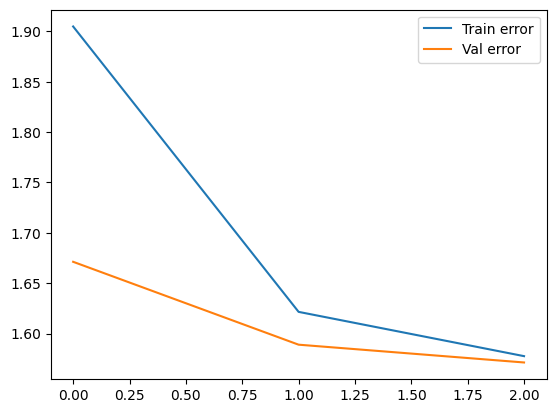

In [72]:
loss, val_loss = history.history["loss"], history.history["val_loss"]
plt.plot(loss, label = "Train error")
plt.plot(val_loss, label = "Val error")
plt.legend()
plt.show()

In [73]:
X_test_final, mask_test = model_encode(
    df_test["processed_text"].to_numpy(),
    fast_tokenizer,
    maxlen = max_length
)

model_predicts = model_v3.predict((X_test_final, mask_test))
predicted_labels = model_predicts.argmax(axis = 1)

print(classification_report(y_test_le, predicted_labels))

100%|██████████| 8/8 [00:00<00:00, 66.21it/s]


63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 184ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       275
           1       0.00      0.00      0.00       224
           2       0.37      0.73      0.49       695
           3       0.00      0.00      0.00       159
           4       0.33      0.36      0.35       581
           5       0.00      0.00      0.00        66

    accuracy                           0.36      2000
   macro avg       0.12      0.18      0.14      2000
weighted avg       0.23      0.36      0.27      2000



In [74]:
print(confusion_matrix(y_test_le, predicted_labels))

[[  0   0 182   0  93   0]
 [  0   0 135   0  89   0]
 [  0   0 506   0 189   0]
 [  0   0 128   0  31   0]
 [  1   0 371   0 209   0]
 [  0   0  51   0  15   0]]


In [75]:
print(accuracy_score(y_test_le, predicted_labels))

0.3575


In [76]:
model_v3.save("model_v3.keras")

In [77]:
from transformers import TFDistilBertModel
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import custom_object_scope

model_loaded = load_model(
    "model_v3.keras",
    custom_objects = {"TransformerLayer": TransformerLayer}
)

text = "i even feel a little shaky"
df_new = pd.DataFrame({'text': [text]})
df_new['processed_text'] = df_new['text'].apply(text_preprocess)
novos_dados = model_encode(df_new['processed_text'], fast_tokenizer, maxlen = max_length)

predict = model_v3.predict(novos_dados)
high_prob_class = np.argmax(predict, axis = 1)

class_name = df_le_v3.inverse_transform(high_prob_class)
class_name

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
100%|██████████| 1/1 [00:00<00:00, 1117.59it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array(['joy'], dtype=object)

In [78]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false
